In [1]:
import torch
from torch_geometric.data import Data, InMemoryDataset
import transformers
from transformers import Trainer, TrainingArguments, HfArgumentParser
import networkx as nx
import matplotlib.pyplot as plt

from script.build_model import build_tokenizer
from src.trainer.trainer import KGLLMTrainer
from config.config import Config
from src.data.datasets import FB15k237Inductive
from src.data.types import CustomData
from src.ultra import tasks, util
from src.ultra.models import Ultra
from src.data.evaluate import EvaluateDataset


def parse_args(config_path: str) -> Config:
    parser = HfArgumentParser(Config)
    cfg: Config = parser.parse_yaml_file(config_path)[0]
    cfg.train = cfg.train.set_dataloader(train_batch_size=cfg.train.batch_size, eval_batch_size=cfg.train.batch_size)

    # get_logger().
    return cfg


def get_data(cfg: Config) -> tuple[InMemoryDataset, CustomData, CustomData, CustomData]:
    dataset = util.build_dataset(cfg)
    return dataset, dataset[0], dataset[1], dataset[2]

/usr/local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/local/lib/python3.12/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [2]:
from src.data.special_tokens import SpecialToken


cfg = parse_args("config/pretrain/pretrain_0.yaml")
transformers.set_seed(cfg.train.seed)

task_name = cfg.task.name
cfg.train.fast_test = -1

# data sampler, loader, collator -> custom trainer
dataset, train_data, valid_data, test_data = get_data(cfg=cfg)

# tokenizer, model = build_tokenizer_model(cfg)
tokenizer = build_tokenizer(cfg)
SpecialToken.add_tokens(tokenizer)

/usr/local/lib/python3.12/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


4

In [161]:
data = EvaluateDataset(test_data, tokenizer, cfg)

In [30]:
item = data[4]

In [31]:
ent_ids = []
for i in range(item.ent_ranges.shape[0]):
    if item.ent_ranges[i][0][0] != -1:
        ent_ids.append(i)

center_ids = item.ht_id + item.neg_t_ids
item.ht_id, str(item.neg_t_ids)

([113, 91], '[114, 124, 190, 150]')

In [32]:
ids_set = set(center_ids)
# filter edge_index, must src and dst all in ids_set
g = nx.Graph()
edge_colors = {}

has_tar_edge = False
for i, v in enumerate(item.data.edge_index.T):
    src, dst = v
    src_item = src.item()
    dst_item = dst.item()

    if src.item() in ids_set and dst.item() in ids_set:
        g.add_edge(src.item(), dst.item())
    elif item.data.super_node_id in [src_item, dst_item]:
        continue
    else:
        pass
        g.add_edge(src.item(), dst.item())

    if src.item() in item.ht_id and dst.item() in item.ht_id and src_item != dst_item:
        if item.data.edge_type[i].item() == item.mask_triples[0][0][-1].item():
            edge_colors[(src_item, dst_item)] = "red"
            has_tar_edge = True
        else:
            edge_colors[(src_item, dst_item)] = "green"
    else:
        edge_colors[(src_item, dst_item)] = "black"

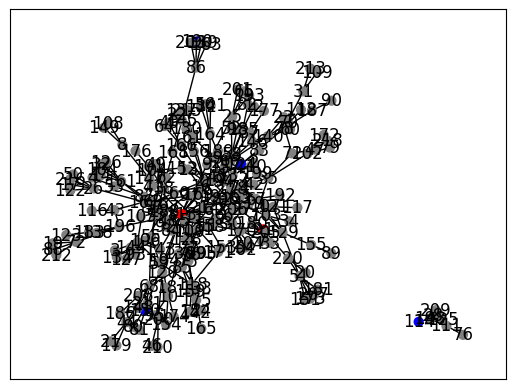

In [33]:
node_color = []
for node in g.nodes():
    if node in item.ht_id:
        node_color.append("red")
    elif node in item.neg_t_ids:
        node_color.append("blue")
    else:
        node_color.append("gray")

pos = nx.spring_layout(g)  # 为图形设置布局
# nx.draw(g, pos, node_color=node_color, with_labels=True, node_size=50, )
# 绘制节点
nx.draw_networkx_nodes(g, pos, node_color=node_color, node_size=40)
# 绘制标签
nx.draw_networkx_labels(g, pos)

# 确保每条边的颜色都被正确设置
valid_edges = [(u, v) for u, v in g.edges() if (u, v) in edge_colors or (v, u) in edge_colors]
edge_colors_list = [edge_colors.get(edge, edge_colors.get((edge[1], edge[0]), 'black')) for edge in valid_edges]

# 绘制边
nx.draw_networkx_edges(g, pos, edgelist=valid_edges, edge_color=edge_colors_list)

plt.savefig("test.png")

In [5]:
from tqdm import tqdm
from src.data.evaluate import EvaluateDataset

In [6]:
cfg.dataset.extra_params['version'] = 'v1'
dataset, train_data, valid_data, test_data = get_data(cfg=cfg)

data = EvaluateDataset(test_data, tokenizer, cfg)

In [7]:
len(data)

205

In [8]:
cnt = 0
for _i in tqdm(range(len(data))):
    item = data[_i]
    ent_ids = []
    for i in range(item.ent_ranges.shape[0]):
        if item.ent_ranges[i][0][0] != -1:
            ent_ids.append(i)

    center_ids = item.ht_id + item.neg_t_ids
    ids_set = set(center_ids)
    # filter edge_index, must src and dst all in ids_set
    g = nx.Graph()
    edge_colors = {}

    has_tar_edge = False
    for i, v in enumerate(item.data.edge_index.T):
        src, dst = v
        src_item = src.item()
        dst_item = dst.item()

        if src.item() in ids_set and dst.item() in ids_set:
            g.add_edge(src.item(), dst.item())
        elif item.data.super_node_id in [src_item, dst_item]:
            continue
        else:
            pass
            g.add_edge(src.item(), dst.item())

        if src.item() in item.ht_id and dst.item() in item.ht_id and src_item != dst_item:
            if item.data.edge_type[i].item() == item.mask_triples[0][0][-1].item():
                edge_colors[(src_item, dst_item)] = "red"
                has_tar_edge = True
            else:
                edge_colors[(src_item, dst_item)] = "green"
        else:
            edge_colors[(src_item, dst_item)] = "black"

    if has_tar_edge:
        cnt += 1
print(cnt, len(data))

100%|██████████| 205/205 [00:29<00:00,  6.90it/s]

25 205


In [168]:
"""
v1: 50 411
v2: 123 947
v3: 197 1731
"""

'\nv1: 50 411\nv2: 123 947\n'